Set proper dtypes for smaller memory usage

In [4]:
import os
os.chdir(r"C:\Users\USER\Downloads\archive")
print(os.listdir())


['aisles.csv', 'departments.csv', 'orders.csv', 'order_products__prior.csv', 'order_products__train.csv', 'products.csv']


In [5]:
import pandas as pd

orders=pd.read_csv("orders.csv")
orders["order_id"]=orders["order_id"].astype("int32")
orders["user_id"]=orders["user_id"].astype("int32")
orders["eval_set"]=orders["eval_set"].astype("category")
orders["order_number"]=orders["order_number"].astype("int16")
orders["order_dow"]=orders["order_dow"].astype("int8")
orders["order_hour_of_day"]=orders["order_hour_of_day"].astype("int8")
orders["days_since_prior_order"]=orders["days_since_prior_order"].astype("float32")
orders.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0


In [6]:
#contains the user's final orders
orders_train=pd.read_csv("order_products__train.csv")
orders_train["order_id"]=orders_train["order_id"].astype("int32")
orders_train["product_id"]=orders_train["product_id"].astype("int32")
orders_train["add_to_cart_order"]=orders_train["add_to_cart_order"].astype("int16")
orders_train["reordered"]=orders_train["reordered"].astype("int8")

In [7]:
products=pd.read_csv("products.csv")
products["product_id"]=products["product_id"].astype("int32")
products["product_name"]=products["product_name"].astype("category")
products["aisle_id"]=products["aisle_id"].astype("int16")
products["department_id"]=products["department_id"].astype("int16")

In [8]:
#contains the user's past orders
orders_prior=pd.read_csv("order_products__prior.csv")
orders_prior["order_id"]=orders_prior["order_id"].astype("int32")
orders_prior["product_id"]=orders_prior["product_id"].astype("int32")
orders_prior["add_to_cart_order"]=orders_prior["add_to_cart_order"].astype("int16")
orders_prior["reordered"]=orders_prior["reordered"].astype("int8")

In [9]:
aisles=pd.read_csv("aisles.csv") 
aisles["aisle_id"]=aisles["aisle_id"].astype("int16")
aisles["aisle"]=aisles["aisle"].astype("category")

In [10]:
department=pd.read_csv("departments.csv")
department["department_id"]=department["department_id"].astype("int16")
department["department"]=department["department"].astype("category")


In [11]:
# Missing value check BEFORE merging
print(orders.isna().sum())
print(orders_train.isna().sum())
print(orders_prior.isna().sum())
print(products.isna().sum())
print(aisles.isna().sum())
print(department.isna().sum())


order_id                       0
user_id                        0
eval_set                       0
order_number                   0
order_dow                      0
order_hour_of_day              0
days_since_prior_order    206209
dtype: int64
order_id             0
product_id           0
add_to_cart_order    0
reordered            0
dtype: int64
order_id             0
product_id           0
add_to_cart_order    0
reordered            0
dtype: int64
product_id       0
product_name     0
aisle_id         0
department_id    0
dtype: int64
aisle_id    0
aisle       0
dtype: int64
department_id    0
department       0
dtype: int64


In [12]:
# Vertically concatenate prior and train data to build full user–product purchase history for feature engineering
order_product=pd.concat([orders_train,orders_prior],ignore_index=True)
order_product

,order_id,product_id,add_to_cart_order,reordered
0,1,49302,1,1
1,1,11109,2,1
2,1,10246,3,0
3,1,49683,4,0
4,1,43633,5,1
...,...,...,...,...
33819101,3421083,39678,6,1
33819102,3421083,11352,7,0
33819103,3421083,4600,8,0
33819104,3421083,24852,9,1


In [13]:
#Prepare the training data by merging orders_train_only and product details

orders_train_only=orders[orders["eval_set"]=="train"]
training_data=orders_train_only.merge(orders_train,on="order_id",how="inner")
training_data=training_data.merge(products,on="product_id",how="left")
training_data=training_data.merge(aisles,on="aisle_id",how="left")
training_data=training_data.merge(department,on="department_id",how="left")
training_data.head()
training_data.describe()
training_data.shape


(1384617, 15)

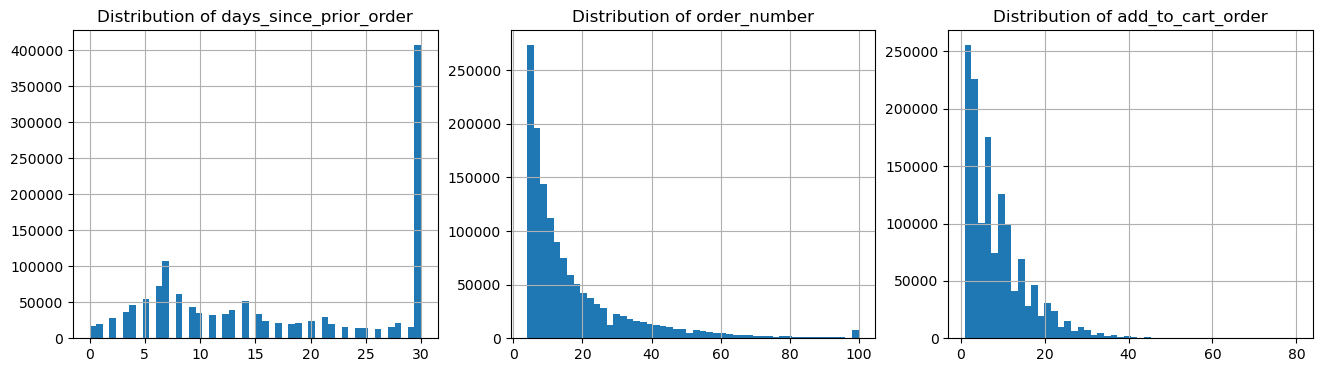

In [14]:
# NaN values in days_since_prior_order were removed by filtering train orders and inner joins.
#print(training_data.isna().sum())

# The target variable (reordered) is not perfectly balanced
training_data["reordered"].value_counts(normalize=True)

# Distribution plots for numeric features:

import matplotlib.pyplot as plt
fig , axes = plt.subplots(1,3,figsize=(16,4))

training_data["days_since_prior_order"].hist(bins=50, ax=axes[0])
axes[0].set_title("Distribution of days_since_prior_order")
training_data["order_number"].hist(bins=50, ax=axes[1])
axes[1].set_title("Distribution of order_number")
training_data["add_to_cart_order"].hist(bins=50, ax=axes[2])
axes[2].set_title("Distribution of add_to_cart_order")
plt.show()

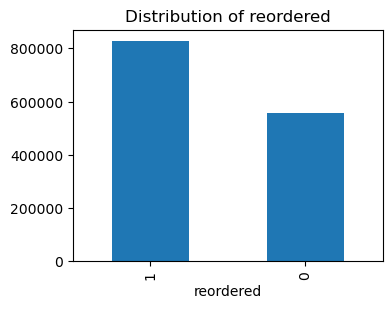

In [15]:
# Distribution plot for Target
plt.figure(figsize=(4,3))
training_data["reordered"].value_counts().plot(kind="bar")
plt.title("Distribution of reordered")
plt.show()

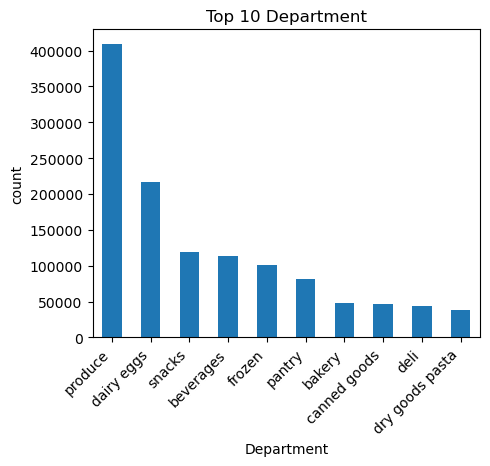

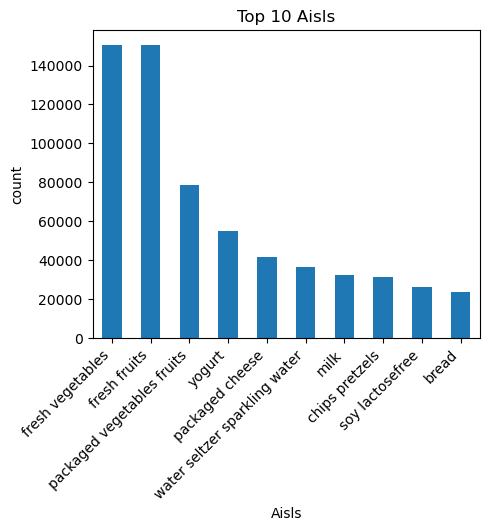

In [16]:
# Categorical cardinality analysis

# Department cardinality and top categories
training_data["department"].unique() #  21 unique catigories
Top_departments=training_data["department"].value_counts().head(10)
plt.figure(figsize=(5,4))
Top_departments.plot(kind="bar")
plt.title("Top 10 Department")
plt.xlabel("Department")
plt.ylabel("count")
plt.xticks(rotation=45,ha="right")
plt.show()


# Aisle cardinality and top categories
training_data["aisle"].unique()     #  134 unique catigories
Top_aisle=training_data["aisle"].value_counts().head(10)
plt.figure(figsize=(5,4))
Top_aisle.plot(kind="bar")
plt.title("Top 10 Aisls")
plt.xlabel("Aisls")
plt.ylabel("count")
plt.xticks(rotation=45,ha="right")
plt.show()

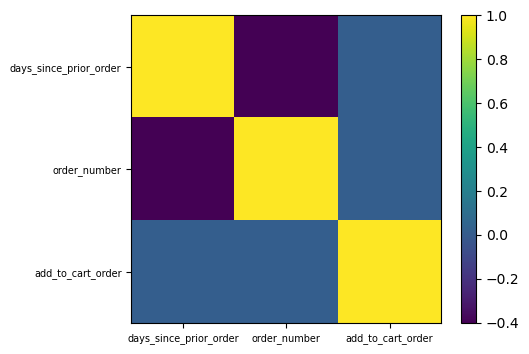

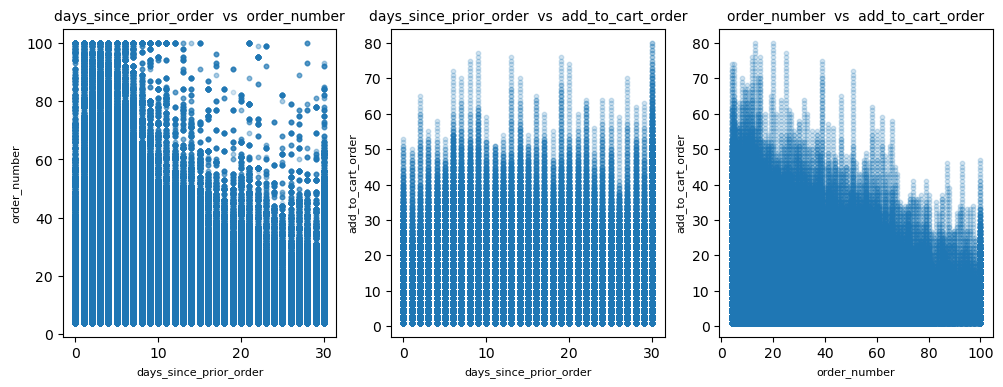

In [17]:
# Correlation matrix and heatmap for selected numeric features

num_col=["days_since_prior_order","order_number","add_to_cart_order"]
corr_matrix=training_data[num_col].corr()
plt.figure(figsize=(5,4))
plt.imshow(corr_matrix,aspect="auto")
plt.colorbar()
plt.xticks(range(len(corr_matrix.columns)),corr_matrix.columns,fontsize=7)
plt.yticks(range(len(corr_matrix.index)),corr_matrix.index,fontsize=7)
plt.show()

# Pairwise scatter plots for selected numeric features
 
pairs=[
       ("days_since_prior_order","order_number"),
       ("days_since_prior_order","add_to_cart_order"),
       ("order_number","add_to_cart_order")
    ]
fig, axes = plt.subplots(1, 3, figsize=(12,4))
for ax,(x,y) in zip(axes,pairs):
    ax.scatter(training_data[x], training_data[y], alpha=0.2, s=10)
    ax.set_xlabel(x,fontsize=8)
    ax.set_ylabel(y,fontsize=8)
    ax.set_title(f"{x}  vs  {y}",fontsize=10)
plt.show()
# The scatter plots show weak linear relationships among the selected numeric features


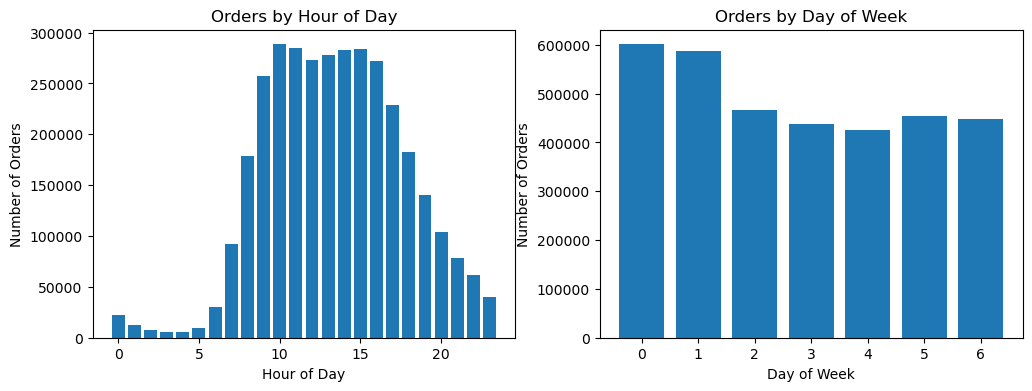

In [18]:
fig, axes = plt.subplots(1, 2, figsize=(12,4))
orders_per_hour=orders["order_hour_of_day"].value_counts().sort_index()
axes[0].bar(orders_per_hour.index,orders_per_hour.values)
axes[0].set_xlabel("Hour of Day")
axes[0].set_ylabel("Number of Orders")
axes[0].set_title("Orders by Hour of Day")
# Order activity varies by time of day, with higher order activity during late morning and afternoon hours.

orders_per_day=orders["order_dow"].value_counts().sort_index()
axes[1].bar(orders_per_day.index,orders_per_day.values)
axes[1].set_xlabel("Day of Week")
axes[1].set_ylabel("Number of Orders")
axes[1].set_title("Orders by Day of Week")
# Orders vary across different days of the week.

plt.show()

Step 3: Data Cleaning & Imputation

In [20]:
# No missing values are present in the dataset, so no imputation is required.
training_data.isnull().sum()


order_id                  0
user_id                   0
eval_set                  0
order_number              0
order_dow                 0
order_hour_of_day         0
days_since_prior_order    0
product_id                0
add_to_cart_order         0
reordered                 0
product_name              0
aisle_id                  0
department_id             0
aisle                     0
department                0
dtype: int64

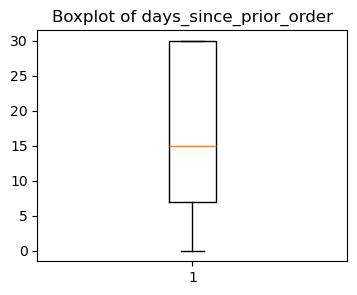

In [21]:
#Outlier detection was performed on the numerical feature days_since_prior_order.
#No significant outliers were identified. therefore, no treatment was applied.

plt.figure(figsize=(4,3))
plt.boxplot(training_data["days_since_prior_order"])
plt.title("Boxplot of days_since_prior_order")
plt.show()
#Right-skewed distribution 

Step 4: Encoding Categorical Variables

In [23]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.preprocessing import OneHotEncoder
from category_encoders import TargetEncoder
from scipy.sparse import hstack, csr_matrix
# define X and y
y = training_data["reordered"]
X = training_data.drop(columns=["reordered"])
# splitting the data
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.2,
    random_state=42,
    stratify=y
)
# One-Hot Encoding for Low-Cardinality Features:
low_car_cols  = ["aisle", "department"]
high_car_cols = ["product_id", "user_id"]
num_cols = [c for c in X_train.select_dtypes(include="number").columns
            if c not in high_car_cols]

preprocess_ohe=ColumnTransformer(
    transformers=[("cat_ohe",OneHotEncoder(handle_unknown="ignore"),low_car_cols),
                 ("num","passthrough",make_column_selector(dtype_include=["number"]))],
    remainder="drop"
)

X_train_ohe =preprocess_ohe.fit_transform(X_train)
X_test_ohe =preprocess_ohe.transform(X_test)


# Frequency Encoding for High-Cardinality Features:

X_train_fe = pd.DataFrame(index=X_train.index)
X_test_fe  = pd.DataFrame(index=X_test.index)

for col in high_car_cols:
    freq_map=X_train[col].value_counts()
    X_train_fe[col +"_freq"]=X_train[col].map(freq_map).fillna(0)
    X_test_fe[col +"_freq"]=X_test[col].map(freq_map).fillna(0)
    
X_train_final_FE = hstack([X_train_ohe, csr_matrix(X_train_fe[[c+"_freq" for c in high_car_cols]].values)])
X_test_final_FE = hstack([X_test_ohe,  csr_matrix(X_test_fe[[c+"_freq" for c in high_car_cols]].values)])




In [24]:
# K-Fold Target Encoding (Leakage-Safe):

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
Xh = X_train[high_car_cols]
X_train_te=pd.DataFrame(index=X_train.index,columns=high_car_cols)

for train_idx, val_idx in skf.split(Xh, y_train):
    te = TargetEncoder(cols=high_car_cols, smoothing=5)
    te.fit(Xh.iloc[train_idx],y_train.iloc[train_idx])
    X_train_te.iloc[val_idx]=te.transform(Xh.iloc[val_idx])[high_car_cols].values

X_train_te=X_train_te.astype("float32")
te_final = TargetEncoder(cols=high_car_cols, smoothing=5)
te_final.fit(X_train[high_car_cols], y_train)
X_test_te = te_final.transform(X_test[high_car_cols]).astype("float32")

X_train_final_TE = hstack([X_train_ohe, csr_matrix(X_train_te.values)])
X_test_final_TE  = hstack([X_test_ohe,  csr_matrix(X_test_te.values)])
print(X_train_final_TE.shape)
print(X_test_final_TE.shape)


(1107693, 167)
(276924, 167)


step 6:Feature Engineering

6.1 User-level feature:

In [58]:
#  total number of orders per user

user_total_orders = (
    X_train.groupby("user_id")["order_number"]
    .max()
    .rename("user_total_orders")
    .reset_index()
)

X_train = X_train.drop(columns=["user_total_orders"], errors="ignore")
X_train = X_train.merge(user_total_orders, on="user_id", how="left")
X_train[["user_id", "user_total_orders"]].head()



,user_id,user_total_orders
0,165784,14
1,122608,8
2,86089,30
3,6875,5
4,25397,23


In [60]:
#  Average basket size:
# compute basket size per order (number of products in each order)

order_basket_size = (
    X_train
    .groupby(["order_id", "user_id"])["product_id"]
    .count()
    .rename("basket_size")
    .reset_index()
)
user_avg_basket = (
    order_basket_size
    .groupby("user_id")["basket_size"]
    .mean()
    .rename("user_avg_basket_size")
    .reset_index()
)

X_train = X_train.drop(columns=["user_avg_basket_size"], errors="ignore")
X_train = X_train.merge(user_avg_basket, on="user_id", how="left")

X_train[["user_id", "user_avg_basket_size"]].head()

,user_id,user_avg_basket_size
0,165784,8.0
1,122608,19.0
2,86089,7.0
3,6875,19.0
4,25397,10.0


In [62]:
#mean days between orders 
user_avg_days_between = (
     X_train
    .groupby("user_id")["days_since_prior_order"]
    .mean()
    .rename("user_avg_days_between_orders")
    .reset_index()
)
X_train = X_train.drop(columns=["user_avg_days_between_orders"], errors="ignore")
X_train = X_train.merge(user_avg_days_between,on="user_id",how="left")

X_train[["user_id", "user_avg_days_between_orders"]].head()


,user_id,user_avg_days_between_orders
0,165784,30.0
1,122608,30.0
2,86089,1.0
3,6875,30.0
4,25397,7.0


In [107]:
# reorder ratio per user
prior = orders_prior.merge(
    orders[["order_id", "user_id"]],
    on="order_id",
    how="left"
)
user_rr = prior.groupby("user_id")["reordered"].mean()
training_data["user_reorder_ratio"] = training_data["user_id"].map(user_rr)

training_data["user_reorder_ratio"].fillna(
    user_rr.mean()
)
X_train[["user_id", "user_reorder_ratio"]].head()

,user_id,user_reorder_ratio
0,165784,0.555556
1,122608,0.565217
2,86089,0.750000
3,6875,0.500000
4,25397,0.357143


In [111]:
#compute last order recency
# 1) add user_id and order_number to prior interactions
prior_hist = orders_prior.merge(
    orders[["order_id", "user_id", "order_number"]],
    on="order_id",
    how="left"
)
# 2) for each (user, product): last order_number in which the product was purchased (from prior)
user_product_last = (
    prior_hist
    .groupby(["user_id", "product_id"])["order_number"]
    .max()
    .rename("user_product_last_order_number")
    .reset_index() 
)
# 3) merge into X_train

X_train = X_train.merge(
    user_product_last,
    on=["user_id", "product_id"],
    how="left",
)
# 4) recency = how many orders since last purchase
X_train["user_product_recency"] = X_train["order_number"] - X_train["user_product_last_order_number"]
# 5) if never purchased before, set recency to current order_number (a large value)
X_train["user_product_recency"] = X_train["user_product_recency"].fillna(X_train["order_number"])
# check
X_train[["user_id", "product_id", "order_number", "user_product_recency"]].head()

,user_id,product_id,order_number,user_product_recency
0,165784,21955,14,2.0
1,122608,47209,8,1.0
2,86089,49113,30,8.0
3,6875,26940,5,5.0
4,25397,12975,23,23.0


6.2 Product-level features

In [118]:
# Overall reorder rate
product_rr = (
    orders_prior
    .groupby("product_id")["reordered"]
    .mean()
    .rename("product_reorder_rate")
)
training_data["product_reorder_rate"] = training_data["product_id"].map(product_rr)

# For new products with no history, we assign the global mean reorder rate
training_data["product_reorder_rate"] = training_data["product_reorder_rate"].fillna(
    orders_prior["reordered"].mean()
)
product_rr.head()

In [128]:
# Average position in cart
product_cart_pos = (
    orders_prior
    .groupby("product_id")["add_to_cart_order"]
    .mean()
    .rename("product_avg_cart_position")
)
training_data["product_avg_cart_position"] = (
    training_data["product_id"].map(product_cart_pos)
)
global_cart_pos = orders_prior["add_to_cart_order"].mean()
training_data["product_avg_cart_position"] = (
    training_data["product_avg_cart_position"].fillna(global_cart_pos)
    )

product_cart_pos.head()

product_id
1    5.801836
2    9.888889
3    6.415162
4    9.507599
5    6.466667
Name: product_avg_cart_position, dtype: float64

In [137]:
# popularity over time

#per-user cutoff (recent = last 20% of each user's orders)
prior_hist["user_cutoff"] = (
    prior_hist.groupby("user_id")["order_number"]
    .transform(lambda s: s.quantile(0.8))
)
recent = prior_hist[prior_hist["order_number"] >= prior_hist["user_cutoff"]]
past  = prior_hist[prior_hist["order_number"] <  prior_hist["user_cutoff"]]

# split into recent and past
recent_counts = recent.groupby("product_id").size()
past_counts   = past.groupby("product_id").size()

# Compute popularity trend with smoothing to avoid division by zero
product_popularity_trend = ((recent_counts + 1) / (past_counts + 1)).rename(
    "product_popularity_trend"
)
training_data["product_popularity_trend"] = training_data["product_id"].map(product_popularity_trend)

# neutral value for missing products
training_data["product_popularity_trend"] = training_data["product_popularity_trend"].fillna(1.0)
